# Report 2: Theft Over Open Data (TOOD)

> This file is intended to be used as references for sections 3 - 5 which all involves model training, 
> testing, and deployment of the model. Creativity and innovation are encouraged for this and other 
> sections moving forward.

**What is the purpose of this file?**

This notebook will be covering parts 3-5 of the assignment namely going over the following:
1. Predictive Model Building - Building the Predictive Model using Modules within `sklearn`.
2. Model Scoring and Evaluation - Evaluation and Scoring of the Model with Training Data.
3. Model Deployment - Deployment of the model as `.pkl` files.

**NOTE**: The naming of this notebook is intentionally, as it stands for the following:
- `c309` - This is the course code COMP309.
- `r2` - This is the report number which is report 2 of the group project.
- `toodu` - This is the name of the dataset we named and will continue working with in this notebook.
- `model` - This is just a generic name but this notebook will contain sections 3 - 5 which all involves model training, testing, and deployment of the model.

**NOTE**: Provided below is a notebook that includes the above sections, thoroughly covering all aspects of sections 3-5. When required, there will be additional informaiton and insights throughout the notebook to help understand the specifics of the model, algorithms used, and how we handle imbalanced data when training the model.

In [2]:
import os
import json
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DEFAULT_DATA_PATH = os.path.join(os.pardir, "data")

toodu_ft_df = pd.read_csv(os.path.join(DEFAULT_DATA_PATH, "Theft_Over_Open_Data_Cleaned.csv"))

**Observation**: The Theft Over Dataset has a noticeable glaring issue, in that much of its data for different offense overlaps with others making it hard to predict them. As such a decision was made to merge the 6 smaller offence 
types into Theft Over. This is because many of them are already classified as sub categories of Theft Over. This Dataset sorts into 3 `UCR_CODE` categories. One is for `Theft Over`, the 2nd for `Motor Vehicle Over` and the 3rd for `Shoplifting`. `Shoplifting` however as well, shares many similarities to `Theft Over`, it's difference being that it is a theft attempted from an open retail store of merchandise. However, the two would often target the same types of locations, and the difference in charge is not a meaningful difference from `Theft Over` itself. The only one that truly differentiates itself is Theft From Motor Vehicle Over, the rest almost always being theft from similar locations.

**Observation (Continue):** When it comes to features, while many columns appeared as though they would be useful such as using the latitude and longitude columns, or the neighbourhood codes, we found that while when included these had a higher importance than `PREMISES_CODE` or `LOCATION_CODE`, they were also a negative impact on the ability of the model to predict the outcome properly. This appears to be because it would then attempt to associate a neighbourhood with a type of crime which resulted in many improper predictions. However, adding another feature could then cause the model to basically ignore those high importance features. We found that these two features we went with, were the most relevant, and were the features that consistently didn't swing back and forth on importance and stayed very consistent between different feature combinations.

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

theft_over_categories = {
    "Theft - Misapprop Funds Over",
    "Theft Over - Bicycle",
    "Theft Over - Distraction",
    "Theft Over",
    "Theft Over - Shoplifting",
    "Theft Of Utilities Over",
    "Theft From Mail / Bag / Key"
}

toodu_ft_df["OFFENCE"] = toodu_ft_df["OFFENCE"].replace(theft_over_categories, "Theft Over")

le = LabelEncoder()
toodu_ft_df["OFFENCE_ENCODED"] = le.fit_transform(toodu_ft_df["OFFENCE"])

categorical_features = [
    "PREMISES_TYPE",
    "LOCATION_TYPE",
    "HOOD_158",
]

numerical_features = [
    "LONG_WGS84",
    "LAT_WGS84",
    "OCC_HOUR",
    "REPORT_HOUR",
]

label_encoders = {}

for col in categorical_features:
    label_encoders[col] = LabelEncoder()
    toodu_ft_df[col] = label_encoders[col].fit_transform(toodu_ft_df[col])

In [5]:
features_filtered = toodu_ft_df[categorical_features]
features_filtered

,PREMISES_TYPE,LOCATION_TYPE,HOOD_158
0,1,17,139
1,5,33,158
2,1,17,64
3,0,0,134
4,1,17,42
...,...,...,...
13951,4,18,149
13952,1,17,84
13953,5,24,107
13954,0,0,84


In [7]:
target_filtered = toodu_ft_df["OFFENCE_ENCODED"]
target_filtered

0        1
1        1
2        1
3        1
4        1
        ..
13951    1
13952    1
13953    0
13954    1
13955    1
Name: OFFENCE_ENCODED, Length: 13956, dtype: int32

In [8]:
scaler = StandardScaler()

toodu_ft_df[numerical_features] = scaler.fit_transform(toodu_ft_df[numerical_features])
features_filtered = toodu_ft_df[categorical_features + numerical_features]
features_filtered

,PREMISES_TYPE,LOCATION_TYPE,HOOD_158,LONG_WGS84,LAT_WGS84,OCC_HOUR,REPORT_HOUR
0,1,17,139,-0.120239,0.147608,1.571788,2.099798
1,5,33,158,7.404010,-7.404004,-1.206015,-1.933282
2,1,17,64,-0.128585,0.128547,0.840787,1.250729
3,0,0,134,-0.135442,0.147352,-1.498415,2.099798
4,1,17,42,-0.128736,0.147478,1.133187,1.462996
...,...,...,...,...,...,...,...
13951,4,18,149,-0.134030,0.122907,-0.328814,-0.659678
13952,1,17,84,-0.133221,0.129107,-0.328814,-0.022875
13953,5,24,107,-0.123229,0.138404,-0.767414,-0.871945
13954,0,0,84,-0.133784,0.130169,-1.790815,-1.084212


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(features_filtered, target_filtered, test_size=0.2, random_state=42)

In [8]:
!pip install imbalanced-learn

In [10]:
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

target_offences = ["Theft From Motor Vehicle Over", "Theft Over"]
mask = y_train.isin([le.transform([offense])[0] for offense in target_offences])

categorical_indices = [features_filtered.columns.get_loc(col) for col in categorical_features]
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)

x_resampled, y_resampled = smote_nc.fit_resample(features_filtered, target_filtered)

x_other = x_train[~mask]
y_other = y_train[~mask]

x_train_balanced = np.vstack((x_other, x_resampled))
y_train_balanced = np.hstack((y_other, y_resampled))

x_train, y_train = x_train_balanced, y_train_balanced

In [11]:
SAMPLES_PER_CLASS = 1500

unique_classes = np.unique(y_train).tolist()
sampling_strategy = {cls: min(SAMPLES_PER_CLASS, (y_train == cls).sum()) for cls in unique_classes}

under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
x_train, y_train = under_sampler.fit_resample(x_train, y_train)

In [12]:
# This code returns it all to a DataFrame
x_train = pd.DataFrame(x_train, columns=categorical_features + numerical_features)


In [13]:
# NOTE: Start of Model Creating and Training

# NOTE: Also can add the following: n_jobs=5, C=100 | C=0.01
# Model: Logistic Regression (SMOTENC Variation)
model = LogisticRegression(solver="liblinear", random_state=42)
model.fit(x_train, y_train)

# Model: Decision Tree Model (SMOTENC Variation)
# NOTE: You can also try: criterion="gini", max_depth=6 (best)
model_dt = DecisionTreeClassifier(criterion="entropy", min_samples_split=20, random_state=42)
model_dt.fit(x_train, y_train)

# Model: Random Forest Model (SMOTENC Variation)
model_rfc = RandomForestClassifier(random_state=42)
model_rfc.fit(x_train, y_train)

score_model = lambda model, x_test, y_test: model.score(x_test, y_test)

In [14]:
# Score Model: LogisticRegression
score_model(model, x_test=x_test, y_test=y_test)

0.7636103151862464

In [15]:
# Score Model: DecisionTreeClassifier
score_model(model_dt, x_test=x_test, y_test=y_test)

0.7847421203438395

In [16]:
# Score Model: RandomForestClassifier
score_model(model_rfc, x_test=x_test, y_test=y_test)

0.8459885386819485

In [17]:
def check_model_json_exists(existing_models, model_name):
    return any(m.get("model") == model_name for m in existing_models)

In [30]:
# NOTE: Start of Model Scoring and Evaluation (Classification Reports)
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score
import pickle

SAVE_DIR = os.path.join(os.pardir, "models", "")

def evaluate_and_save_model(model, x_train, x_test, y_train, y_test, file_name):
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:10]
    
    y_pred_inverse = le.inverse_transform(y_pred)
    y_test_inverse = le.inverse_transform(y_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    file_path = os.path.join(SAVE_DIR, file_name)
    models_json_path = os.path.join(SAVE_DIR, "models.json")

    
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
    
    model_metadata = {
        "model": model.__class__.__name__,
        "accuracy": accuracy,
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "classification_report": classification_report(y_test, y_pred, output_dict=True)
    }
    
    
    try:
        if os.path.exists(models_json_path) and os.path.getsize(models_json_path) > 0:
            with open(models_json_path, "r") as file:
                existing_models = json.load(file)
            
        else:
            existing_models = []

        if not check_model_json_exists(
                existing_models=existing_models, 
                model_name=model.__class__.__name__):
            existing_models.append(model_metadata)
        
        with open(models_json_path, "w") as file:
            json.dump(existing_models, file, indent=4)
            
        with open(file_path, "wb") as file:
            pickle.dump(model, file)
            
    except Exception as e:
        print(f"Error Occurred: {e}")

    print(f"""
    Model: {model.__class__.__name__}
    Accuracy: {accuracy:.4f}
    Training Accuracy: {model.score(x_train, y_train)}
    Classification Report: {classification_report(y_test, y_pred)}
    Predictions: {y_pred_inverse}
    Prediction Probabilities: {y_pred_proba}
    Y Values: {y_test.value_counts()}
    ----
    Model Saved To: {file_path}
    Model Metadata Added To: {models_json_path}
    """)

In [31]:
# Save Model: LogisticRegression
evaluate_and_save_model(model=model, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, file_name="lr_model_smotenc.pkl")


    Model: LogisticRegression
    Accuracy: 0.7636
    Training Accuracy: 0.7646666666666667
    Classification Report:               precision    recall  f1-score   support

           0       0.52      0.76      0.62       700
           1       0.90      0.77      0.83      2092

    accuracy                           0.76      2792
   macro avg       0.71      0.76      0.72      2792
weighted avg       0.81      0.76      0.78      2792

    Predictions: ['Theft Over' 'Theft Over' 'Theft Over' ...
 'Theft From Motor Vehicle Over' 'Theft Over'
 'Theft From Motor Vehicle Over']
    Prediction Probabilities: [[0.32474365 0.67525635]
 [0.24085013 0.75914987]
 [0.14912551 0.85087449]
 [0.27791889 0.72208111]
 [0.7560968  0.2439032 ]
 [0.15226112 0.84773888]
 [0.22031448 0.77968552]
 [0.42470425 0.57529575]
 [0.08465022 0.91534978]
 [0.72190207 0.27809793]]
    Y Values: OFFENCE_ENCODED
1    2092
0     700
Name: count, dtype: int64
    ----
    Model Saved To: ..\models\lr_model_smoten

In [32]:
# Save Model: DecisionTreeClassifier
evaluate_and_save_model(model=model_dt, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, file_name="dt_model_smotenc.pkl")


    Model: DecisionTreeClassifier
    Accuracy: 0.7847
    Training Accuracy: 0.892
    Classification Report:               precision    recall  f1-score   support

           0       0.55      0.75      0.64       700
           1       0.90      0.80      0.85      2092

    accuracy                           0.78      2792
   macro avg       0.73      0.77      0.74      2792
weighted avg       0.82      0.78      0.79      2792

    Predictions: ['Theft Over' 'Theft Over' 'Theft Over' ...
 'Theft From Motor Vehicle Over' 'Theft Over'
 'Theft From Motor Vehicle Over']
    Prediction Probabilities: [[0.         1.        ]
 [0.33333333 0.66666667]
 [0.17647059 0.82352941]
 [0.21052632 0.78947368]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.875      0.125     ]
 [0.         1.        ]
 [1.         0.        ]]
    Y Values: OFFENCE_ENCODED
1    2092
0     700
Name: count, dtype: int64
    ----
    Model Saved To: ..\models\dt_model_smotenc.pkl
   

In [33]:
# Save Model: RandomForestClassifier
evaluate_and_save_model(model=model_rfc, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, file_name="rf_model_smotenc.pkl")


    Model: RandomForestClassifier
    Accuracy: 0.8460
    Training Accuracy: 1.0
    Classification Report:               precision    recall  f1-score   support

           0       0.66      0.79      0.72       700
           1       0.92      0.86      0.89      2092

    accuracy                           0.85      2792
   macro avg       0.79      0.83      0.81      2792
weighted avg       0.86      0.85      0.85      2792

    Predictions: ['Theft Over' 'Theft Over' 'Theft Over' ... 'Theft Over' 'Theft Over'
 'Theft Over']
    Prediction Probabilities: [[0.1  0.9 ]
 [0.26 0.74]
 [0.14 0.86]
 [0.34 0.66]
 [0.95 0.05]
 [0.   1.  ]
 [0.03 0.97]
 [0.73 0.27]
 [0.03 0.97]
 [0.58 0.42]]
    Y Values: OFFENCE_ENCODED
1    2092
0     700
Name: count, dtype: int64
    ----
    Model Saved To: ..\models\rf_model_smotenc.pkl
    Model Metadata Added To: ..\models\models.json
    


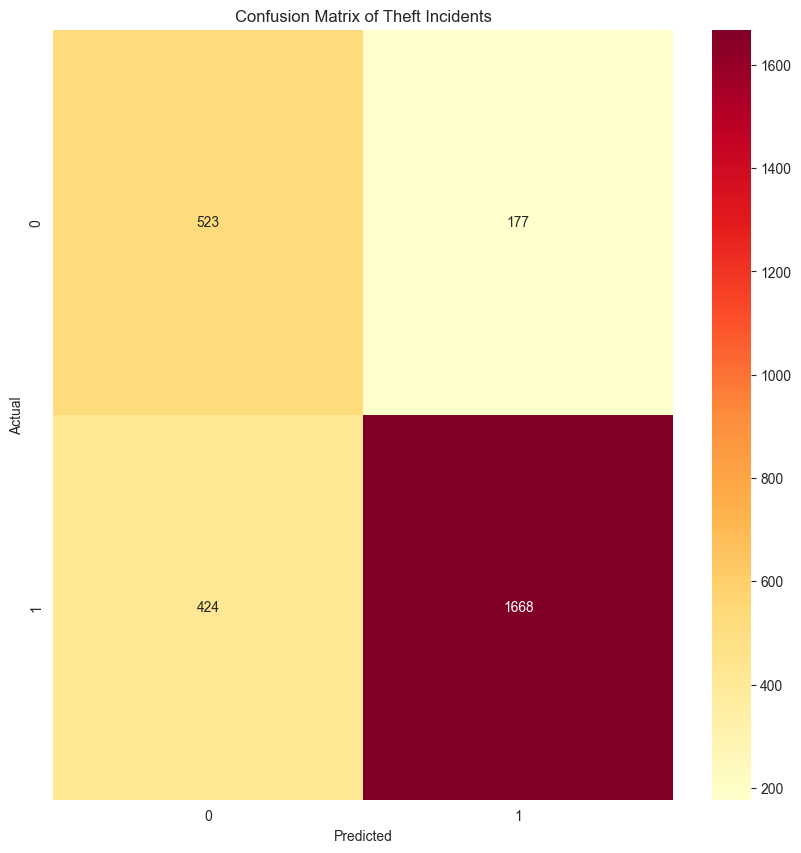

In [19]:
# NOTE: Start of Confusion Matrix and Visualizations
from sklearn.metrics import confusion_matrix

y_pred_dt = model_dt.predict(x_test)
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(10, 10))
sns.heatmap(cm_dt, annot=True, cmap="YlOrRd", fmt="d")
plt.title("Confusion Matrix of Theft Incidents")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

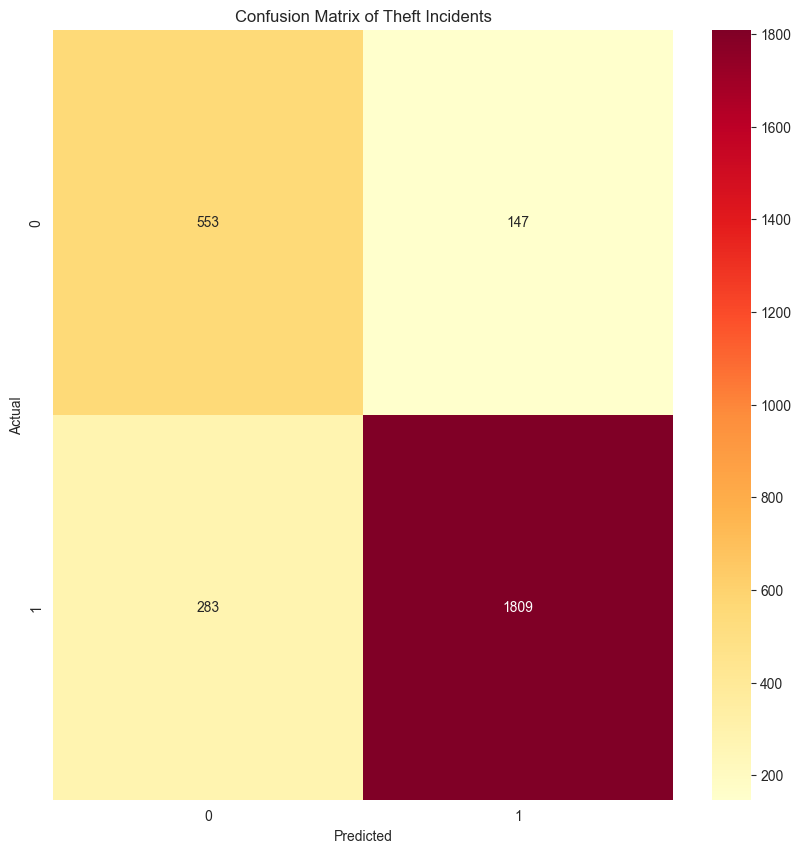

In [20]:
y_pred_rfc = model_rfc.predict(x_test)
cm_rfc = confusion_matrix(y_test, y_pred_rfc)

plt.figure(figsize=(10, 10))
sns.heatmap(cm_rfc, annot=True, cmap="YlOrRd", fmt="d")
plt.title("Confusion Matrix of Theft Incidents")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

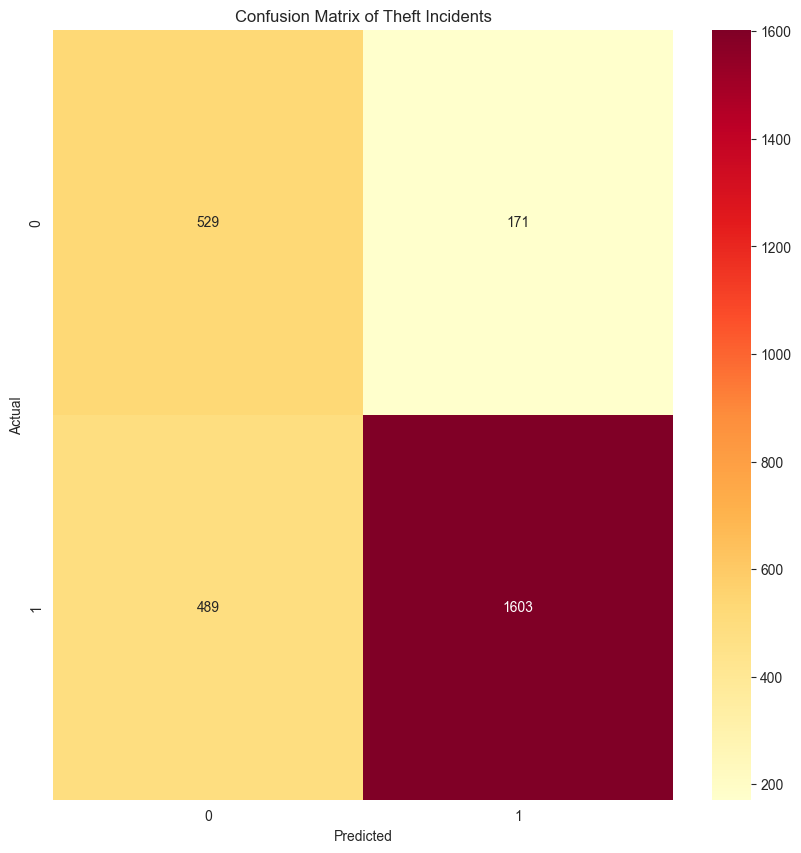

In [21]:
y_pref = model.predict(x_test)
cm = confusion_matrix(y_test, y_pref)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap="YlOrRd", fmt="d")
plt.title("Confusion Matrix of Theft Incidents")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [44]:
# NOTE: Calculating Roc_Curve, Auc
from sklearn.metrics import roc_curve, auc
from enum import Enum

class ModelType(Enum):
    LOGISTIC_REGRESSION = "lr"
    RANDOM_FOREST = "rf"
    DECISION_TREE = "dt"


def calculate_roc_auc_score(y_test, model_type: ModelType) -> tuple:
    y_score = ""
    match model_type:
        case ModelType.LOGISTIC_REGRESSION:
            y_score = model.predict_proba(x_test)[:, 1]
            
        case ModelType.RANDOM_FOREST:
            y_score = model_rfc.predict_proba(x_test)[:, 1]
            
        case ModelType.DECISION_TREE:
            y_score = model_dt.predict_proba(x_test)[:, 1]
        
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f"AUC: {roc_auc:.4f}", color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    
    print(f"""
    y_score: {y_score}
    roc_auc: {roc_auc:.4f}
    """)
    
    return y_score, fpr, tpr, roc_auc

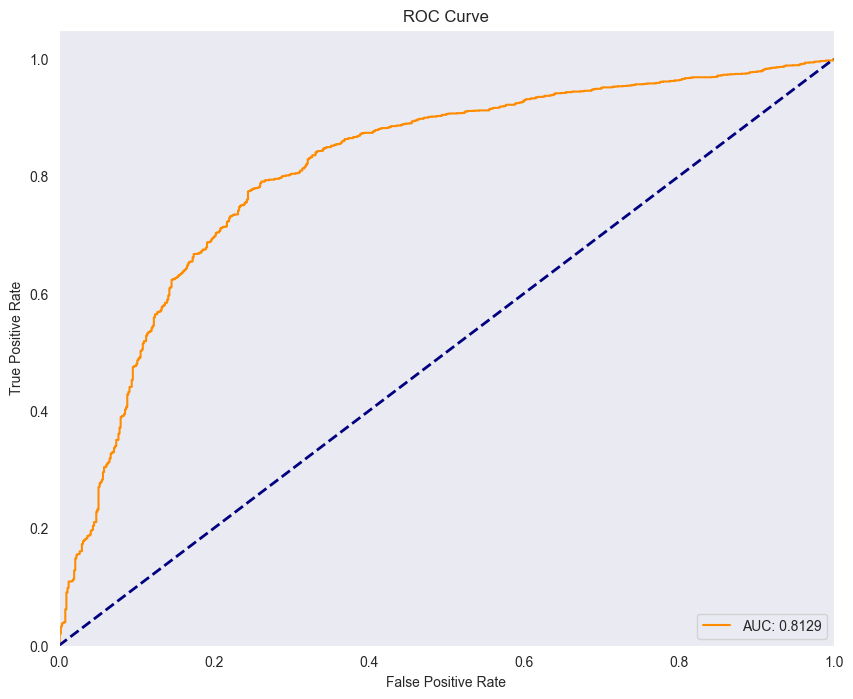


    y_score: [0.67525635 0.75914987 0.85087449 ... 0.39792327 0.76494708 0.39389848]
    roc_auc: 0.8129
    


In [45]:
# ROC Curve for Logistic Regression
y_score_lr, fpr_lr, tpr_lr, roc_auc_lr = calculate_roc_auc_score(y_test=y_test, model_type=ModelType.LOGISTIC_REGRESSION)

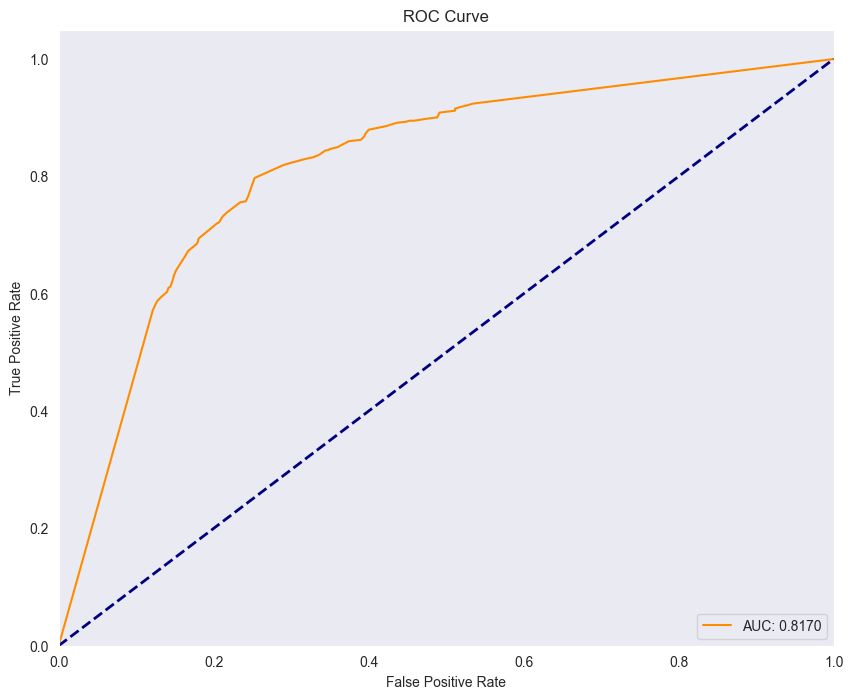


    y_score: [1.         0.66666667 0.82352941 ... 0.         0.85714286 0.16666667]
    roc_auc: 0.8170
    


In [46]:
# ROC Curve for Decision Tree Classifier
y_score_dt, fpr_dt, tpr_dt, roc_auc_dt = calculate_roc_auc_score(y_test=y_test, model_type=ModelType.DECISION_TREE)

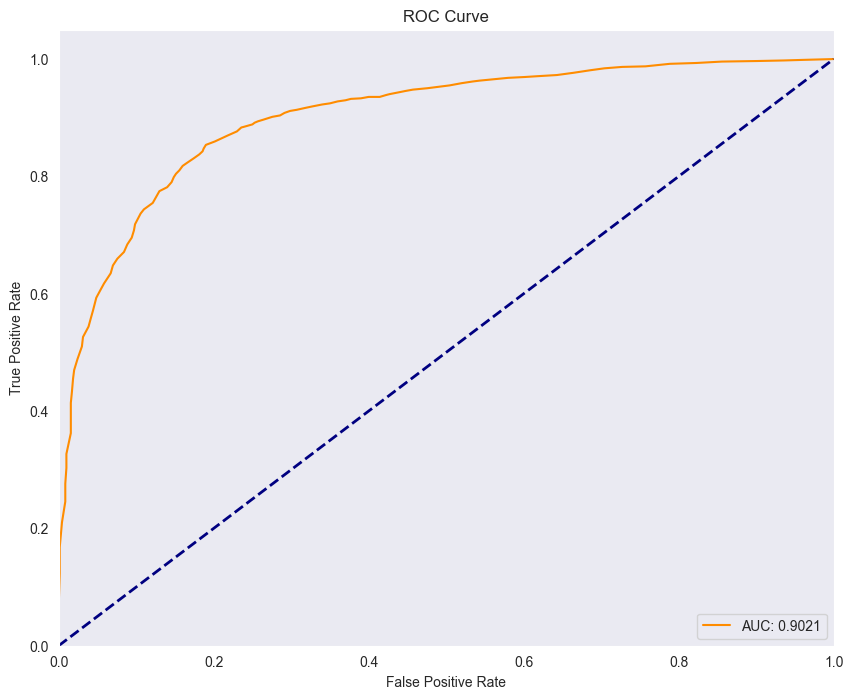


    y_score: [0.9  0.74 0.86 ... 0.73 0.76 0.65]
    roc_auc: 0.9021
    


In [47]:
# ROC Curve for Random Forest Classifier
y_score_rfc, fpr_rfc, tpr_rfc, roc_auc_rfc = calculate_roc_auc_score(y_test=y_test, model_type=ModelType.RANDOM_FOREST)

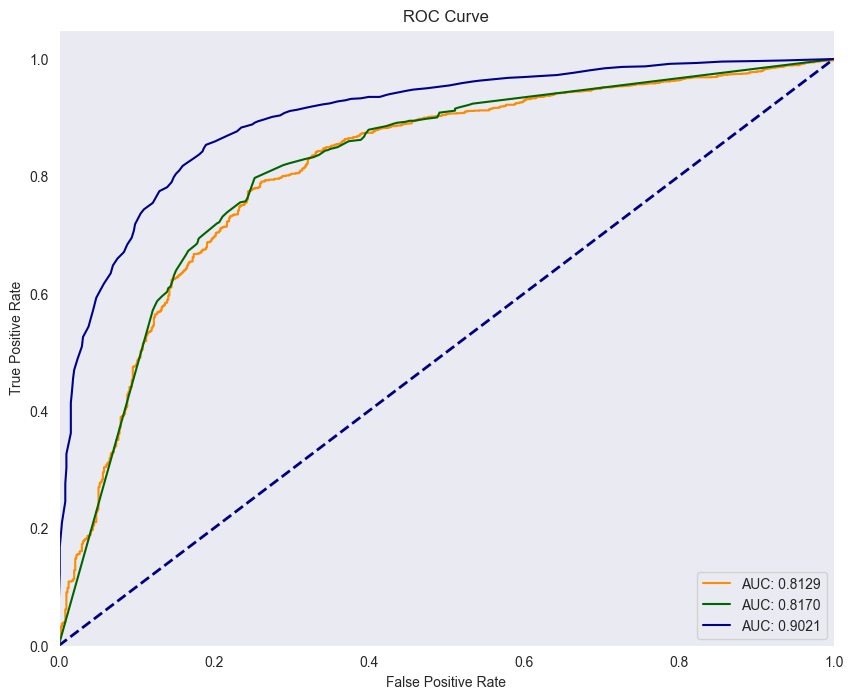

In [48]:
# NOTE: Combined Visualization of ROC Curves

fig = plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f"AUC: {roc_auc_lr:.4f}", color="darkorange")
plt.plot(fpr_dt, tpr_dt, label=f"AUC: {roc_auc_dt:.4f}", color="darkgreen")
plt.plot(fpr_rfc, tpr_rfc, label=f"AUC: {roc_auc_rfc:.4f}", color="darkblue")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [49]:
# NOTE: Classification Metrics Function to Calculate Metrics

def calculate_classification_metrics(TP, TN, FP, FN):
    classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
    classification_error = (FP + FN) / float(TP + TN + FP + FN)
    precision_score = TP / float(TP + FP)
    recall_score = TP / float(TP + FN)
    true_positive_rate = TP / float(TP + FN)
    false_positive_rate = FP / float(FP + TN)
    
    print(f"""
    Classification Accuracy: {classification_accuracy}
    Classification Error:    {classification_error}
    Precision Score:         {precision_score}
    Recall Score:            {recall_score}
    True Positive Rate:      {true_positive_rate}
    False Positive Rate:     {false_positive_rate}
    """)

In [50]:
# Classification Metrics for Decision Tree Classifier
calculate_classification_metrics(
    TP=cm_dt[0, 0],
    TN=cm_dt[1, 1],
    FP=cm_dt[0, 1],
    FN=cm_dt[1, 0]
)


    Classification Accuracy: 0.7847421203438395
    Classification Error:    0.21525787965616044
    Precision Score:         0.7471428571428571
    Recall Score:            0.5522703273495249
    True Positive Rate:      0.5522703273495249
    False Positive Rate:     0.0959349593495935
    


In [51]:
# Classification Metrics for Random Forest Classifier
calculate_classification_metrics(
    TP=cm_rfc[0, 0],
    TN=cm_rfc[1, 1],
    FP=cm_rfc[0, 1],
    FN=cm_rfc[1, 0]
)


    Classification Accuracy: 0.8459885386819485
    Classification Error:    0.15401146131805157
    Precision Score:         0.79
    Recall Score:            0.6614832535885168
    True Positive Rate:      0.6614832535885168
    False Positive Rate:     0.07515337423312883
    


In [52]:
# Classification Metrics for Logistic Regression
calculate_classification_metrics(
    TP=cm[0, 0],
    TN=cm[1, 1],
    FP=cm[0, 1],
    FN=cm[1, 0]
)


    Classification Accuracy: 0.7636103151862464
    Classification Error:    0.23638968481375358
    Precision Score:         0.7557142857142857
    Recall Score:            0.5196463654223968
    True Positive Rate:      0.5196463654223968
    False Positive Rate:     0.0963923337091319
    


In [28]:
# NOTE: Graphviz Implementation for Decision Tree Classifier

from sklearn.tree import export_graphviz

DOT_PATH = os.path.join(os.pardir, "img")
try:  
    export_graphviz(
        model_dt, 
        out_file=os.path.join(DOT_PATH, "dt.dot"), 
        class_names=["Theft Over", "Auto Theft"],
        filled=True,
        rounded=True,
        special_characters=True
    )
except Exception as e:
    print(f"Error occured while exporting graph: {str(e)}")

In [29]:
toodu_ft_df.to_csv(os.path.join(DEFAULT_DATA_PATH, "Theft_Over_Data_Cleaned_Encoded.csv"), index=False)